In [1]:
import sys
sys.path.insert(1, '../')
import torch

from spiral import (
    IntegrateAndFireSoma,
    LeakyMembrane,
    LinearDendrite
)
LIF = (LeakyMembrane(IntegrateAndFireSoma))
new_n = lambda: LIF(
    name='neuronsA',
    shape=(5,),
    batch=1,
    dt=1.,
    analyzable=True,
)

In [15]:
from spiral.analysis import FunctionGenerator
neurotransmitter = FunctionGenerator.generate(200, shape=(1,3,1,1),
           baseline={50*i: 150 if i%2 else 0 for i in range(5)})
neurotransmitter[:,:,1] *= 1.2

In [18]:
from spiral.analysis import Simulator
import matplotlib.pyplot as plt
from matplotlib_dashboard import MatplotlibDashboard

def simulate_and_plot(n, d, neurotransmitter, title=''):
    def f(**args):
        d.forward(**args)
        n.progress()
    s = Simulator(f)
    n.reset()
    s.simulate(inputs={'neurotransmitter': neurotransmitter, 'neuromodulator': torch.tensor([0])}, times=200)
    plt.figure(figsize=(14,8))
    md = MatplotlibDashboard([
        ['S',],
        ['P',],
        ['C',],
        ['W',],
        ['N',],
    ], hspace=.5, wspace=.3)
    n.plot_spikes(md['S'])
    n.plot_potential(md['P'])
    d.plot_transmiting_current(md['C'])
    d.plot_synaptic_weights(md['W'])
    md['N'].plot(neurotransmitter.reshape(neurotransmitter.shape[0],-1), color='cyan', alpha=.2)
    md['N'].plot(neurotransmitter.mean(axis=2).reshape(-1), color='cyan')
    md['N'].set_xlim((0,200))
    md['N'].set_ylabel('Current')
    md['S'].set_title(title)
    plt.show()

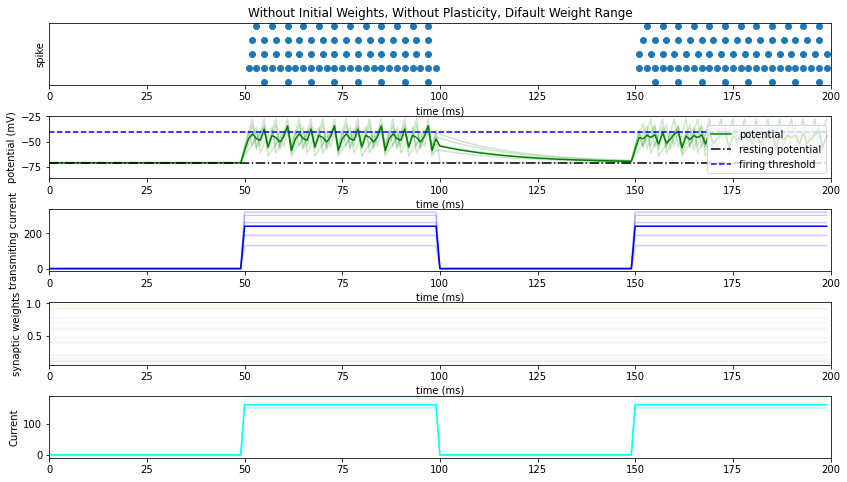

In [19]:
n = new_n()
d = LinearDendrite(
    spine=(3,),
    analyzable=True,
)
n.use(d)
simulate_and_plot(n, d, neurotransmitter, 'Without Initial Weights, Without Plasticity, Difault Weight Range')

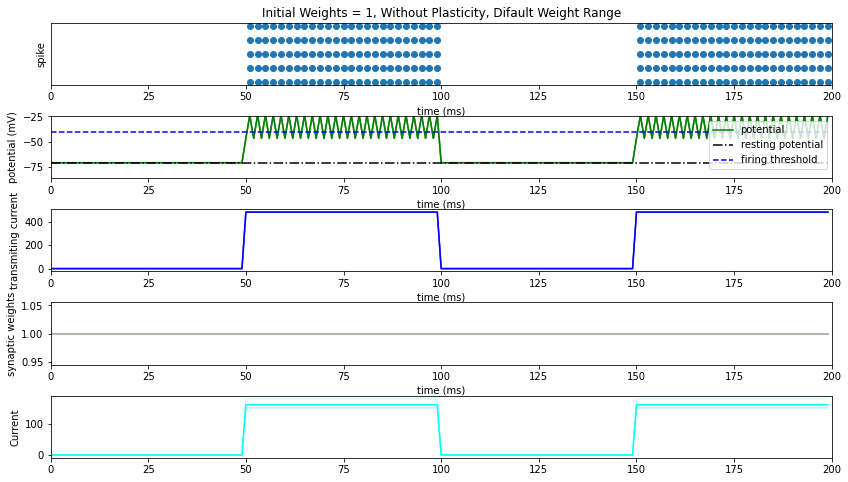

In [20]:
n = new_n()
d = LinearDendrite(
    spine=(3,),
    analyzable=True,
    initial_weights=torch.ones
)
n.use(d)
simulate_and_plot(n, d, neurotransmitter, 'Initial Weights = 1, Without Plasticity, Difault Weight Range')

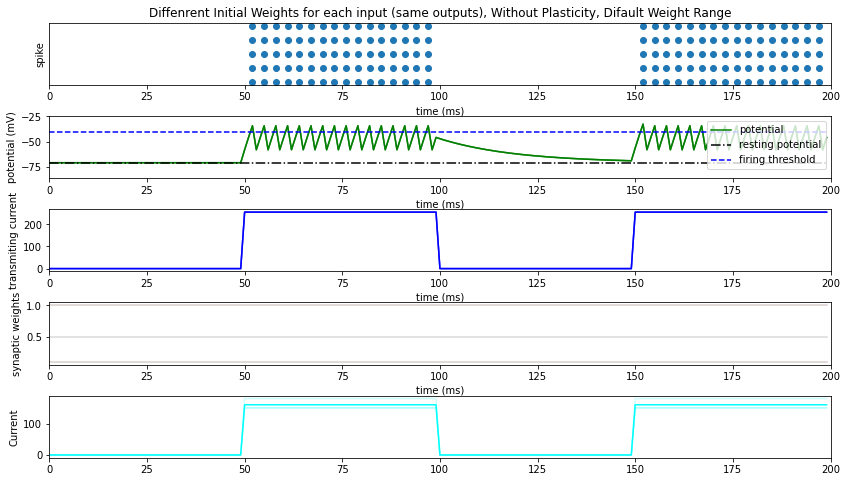

In [21]:
n = new_n()
d = LinearDendrite(
    spine=(3,),
    analyzable=True,
    initial_weights=torch.as_tensor([[.1]*5,[.5]*5,[1]*5])
)
n.use(d)
simulate_and_plot(n, d, neurotransmitter, 'Diffenrent Initial Weights for each input (same outputs), Without Plasticity, Difault Weight Range')

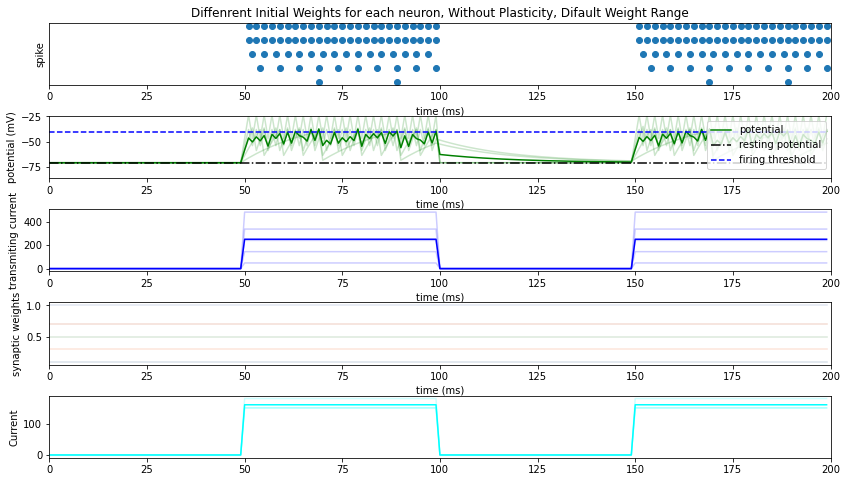

In [22]:
n = new_n()
d = LinearDendrite(
    spine=(3,),
    analyzable=True,
    initial_weights=torch.as_tensor([[.1,.3,.5,.7,1]]*3)
)
n.use(d)
simulate_and_plot(n, d, neurotransmitter, 'Diffenrent Initial Weights for each neuron, Without Plasticity, Difault Weight Range')

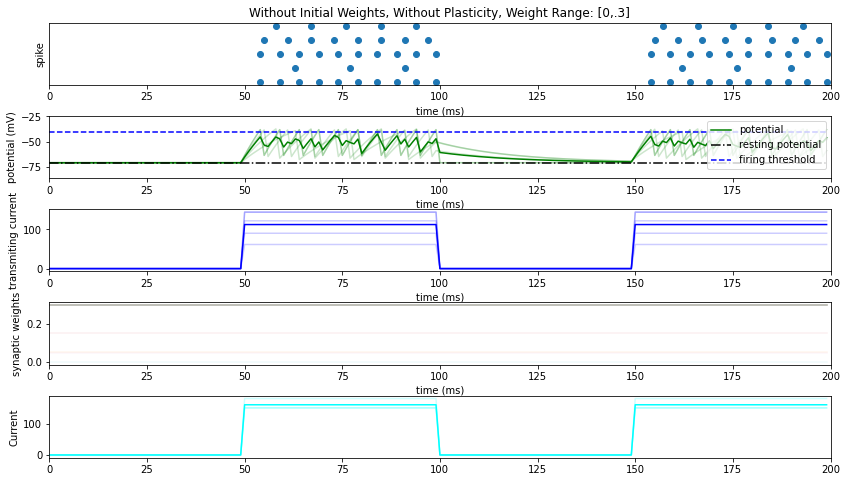

In [23]:
n = new_n()
d = LinearDendrite(
    spine=(3,),
    analyzable=True,
    maximum_weight=.3
)
n.use(d)
simulate_and_plot(n, d, neurotransmitter, 'Without Initial Weights, Without Plasticity, Weight Range: [0,.3]')

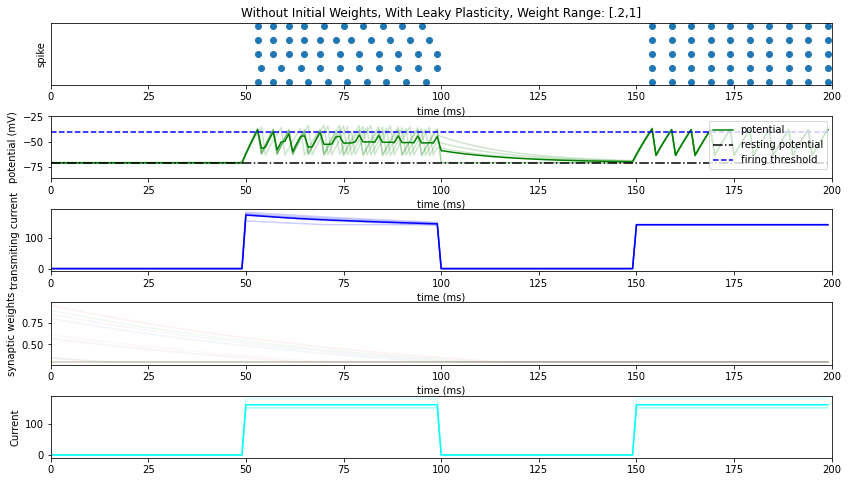

In [24]:
from spiral import ConvergentSynapticPlasticity

n = new_n()
d = LinearDendrite(
    spine=(3,),
    analyzable=True,
    minimum_weight=.3,
    plasticity_model=ConvergentSynapticPlasticity(tau=100.),
)
n.use(d)
simulate_and_plot(n, d, neurotransmitter, 'Without Initial Weights, With Leaky Plasticity, Weight Range: [.2,1]')

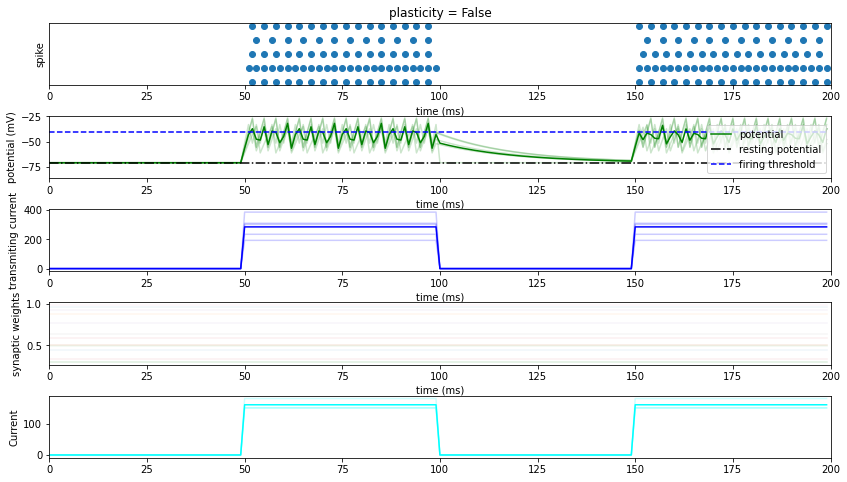

In [25]:
n = new_n()
d = LinearDendrite(
    spine=(3,),
    analyzable=True,
    minimum_weight=.3,
    plasticity_model=ConvergentSynapticPlasticity(tau=100.),
    plasticity=False,
)
n.use(d)
simulate_and_plot(n, d, neurotransmitter, 'plasticity = False')

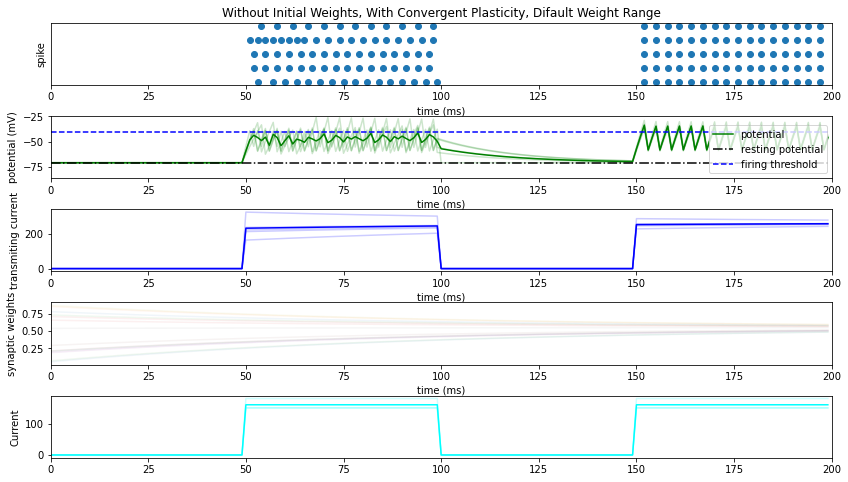

In [26]:
n = new_n()
d = LinearDendrite(
    spine=(3,),
    analyzable=True,
    plasticity_model=ConvergentSynapticPlasticity(convergence=.55, tau=100.)
)
n.use(d)
simulate_and_plot(n, d, neurotransmitter, 'Without Initial Weights, With Convergent Plasticity, Difault Weight Range')

In [30]:
def simulate_and_plot(n, d1, d2, neurotransmitter, title=''):
    def f(**args):
        d1.forward(**args)
        d2.forward(torch.zeros(2,12,1,1), torch.tensor(0.))
        n.progress()
    s = Simulator(f)
    s.simulate(inputs={'neurotransmitter': neurotransmitter, 'neuromodulator': torch.tensor([0])}, times=200)
    plt.figure(figsize=(14,8))
    md = MatplotlibDashboard([
        ['S',],
        ['P',],
        ['C1',],
        ['W1',],
        ['C2',],
        ['W2',],
    ], hspace=.5, wspace=.3)
    n.plot_spikes(md['S'], s=1)
    n.plot_potential(md['P'])
    d1.plot_transmiting_current(md['C1'])
    d1.plot_synaptic_weights(md['W1'])
    d2.plot_transmiting_current(md['C2'])
    d2.plot_synaptic_weights(md['W2'])
    md['S'].set_title(title)
    plt.show()

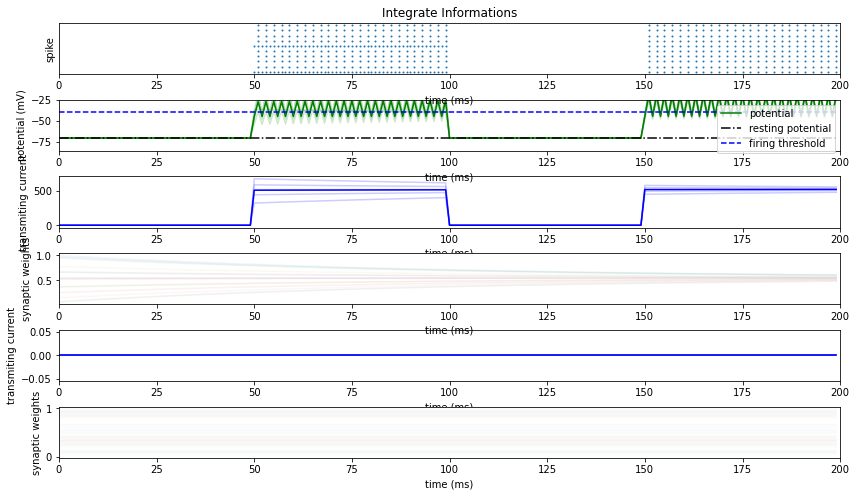

In [32]:
from spiral.analysis import FunctionGenerator
neurotransmitter = FunctionGenerator.generate(250, shape=(2,3,1,1),
           baseline={50*i: 150 if i%2 else 0 for i in range(5)})
neurotransmitter[:,:,1] *= 1.2

n = LIF(
    name='neuronsA',
    analyzable=True,
)
d1 = LinearDendrite(
    shape=(5,),
    spine=(3,),
    batch=2,
    analyzable=True,
    plasticity_model=ConvergentSynapticPlasticity(convergence=.55, tau=100.)
)
d2 = LinearDendrite(
    spine=(12,),
    dt=1.,
    analyzable=True,
)
n.use(d1)
n.use(d2)
simulate_and_plot(n, d1, d2, neurotransmitter, 'Integrate Informations')